In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import time
import math
import experiments.base.toy_regression as exp
import matplotlib.pyplot as plt
from training.regresssion import RegressionResults, plot_calibration, plot_table
from training.util import plot_losses, adam, sgd, nll_loss
from experiments.base.uci import UCIDatasets
from training.pp import MAP
from training.swag import SwagModel
from training.ensemble import Ensemble
from training.bbb import GaussianPrior, BBBModel
from training.sgld import SGLDModule, sgld

/home/flo/anaconda3/envs/bdl2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cpu")

Epoch 0: loss 7.236088752746582
Epoch 100: loss -0.6832857131958008
Epoch 200: loss -0.9441988468170166
Epoch 300: loss -1.0401800870895386
Epoch 400: loss -1.1096440553665161
Epoch 500: loss -1.1435884237289429
Epoch 600: loss -1.0955989360809326
Epoch 700: loss -1.0906552076339722
Epoch 800: loss -1.2078746557235718
Epoch 900: loss -1.2300753593444824
Final loss -1.2393534183502197
| Power   | Avg LML     | Mean MSE     | MSE of Means   | QCE        |
|---------+-------------+--------------+----------------+------------|
| MAP     | -4.27 ± nan | 26.651 ± nan | 26.653 ± nan   | 0.19 ± nan |
MAP & $-4.27 \pm nan$ & $26.65 \pm nan$ & $26.65 \pm nan$ & $0.19 \pm nan$ \\


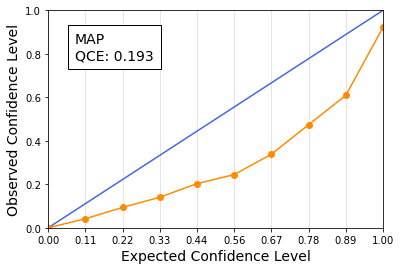

In [40]:
from training.pp import MAP
from training.swag import SwagModel
from training.bbb import BBBModel, GaussianPrior
from training.util import adam
torch.manual_seed(0)

batch_size = 32
dataset = UCIDatasets("housing", "/mnt/d/Uni/Bachelorarbeit/linux/data/", test_percentage=0.2, subsample=1)
trainloader = torch.utils.data.DataLoader(dataset.gap_splits[4][0], batch_size, shuffle=False)
testloader = torch.utils.data.DataLoader(dataset.gap_splits[4][1], batch_size, shuffle=False)
init_var = torch.tensor(0.25).to(device).repeat(dataset.out_dim)
def make_res(name, eval_fn, samples):
    return RegressionResults(testloader, name, eval_fn, samples, device, target_mean=dataset.target_mean, target_std=dataset.target_std)

config = {
    "start_epoch": 150,
    "mean_samples": 50,
    "deviation_samples": 30
}
prior = GaussianPrior(0, 1)
layers = [
    ("fc", (dataset.in_dim, 50)),
    ("relu", ()),
    ("fc", (50, 1)),
    ("gauss", (init_var, False))
]
map_model = MAP(layers)
map_model.train_model(1000, nll_loss, adam(1e-3, 1e-4), trainloader, batch_size, device, report_every_epochs=100)
#model.train_model(50, nll_loss, adam(1e-2), trainloader, batch_size, device, mc_samples=10, report_every_epochs=100)
res = make_res("MAP", map_model.infer, 1000)

plot_table("Power", [[res]])
plot_calibration("MAP", res, plt.subplot())

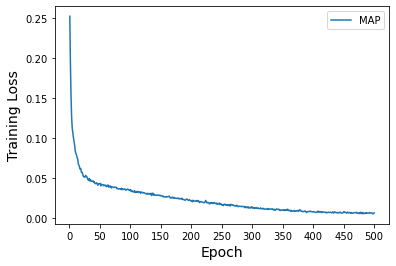

In [64]:
plot_losses("MAP", map_model.all_losses(), plt.subplot())

Epoch 0: loss 9.233732223510742
Epoch 100: loss -0.5105257034301758
Final loss -0.38872596621513367
| Power   | Avg LML     | Mean MSE     | MSE of Means   | QCE        |
|---------+-------------+--------------+----------------+------------|
| MAP     | -2.29 ± nan | 13.341 ± nan | 4.565 ± nan    | 0.14 ± nan |
MAP & $-2.29 \pm nan$ & $13.34 \pm nan$ & $4.56 \pm nan$ & $0.14 \pm nan$ \\


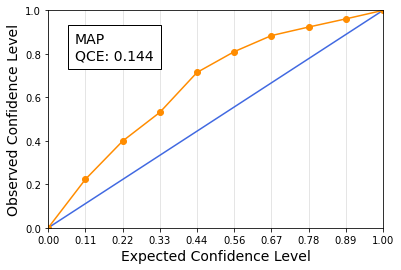

In [42]:
from training.vogn import VOGNModule, iVONModuleFunctorch

torch.manual_seed(0)

batch_size = 32
dataset = UCIDatasets("energy", "/mnt/d/Uni/Bachelorarbeit/linux/data/", test_percentage=0.2, subsample=1)
trainloader = torch.utils.data.DataLoader(dataset.train_set, batch_size, shuffle=False)
testloader = torch.utils.data.DataLoader(dataset.test_set, batch_size, shuffle=False)
init_var = torch.tensor(0.25).to(device).repeat(dataset.out_dim)
def make_res(name, eval_fn, samples):
    return RegressionResults(testloader, name, eval_fn, samples, device, target_mean=dataset.target_mean, target_std=dataset.target_std)

layers = [
    ("fc", (dataset.in_dim, 50)),
    ("relu", ()),
    ("fc", (50, 1)),
    ("gauss", (init_var, False))
]
model = VOGNModule(layers)
model.train_model(200, nll_loss, {"lr": 1e-3, "prior_prec": 10.0, "damping": 1e-4, "betas": (0.9, 0.999), "sample": True}, trainloader, batch_size, device, mc_samples=2, report_every_epochs=100)
#model.train_model(50, nll_loss, adam(1e-2), trainloader, batch_size, device, mc_samples=10, report_every_epochs=100)
res = make_res("MAP", model.infer, 1000)

plot_table("Power", [[res]])
plot_calibration("MAP", res, plt.subplot())

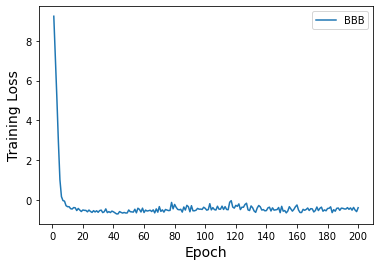

In [43]:
plot_losses("BBB", model.all_losses(), plt.subplot())

Running chain 0
Epoch 0: loss 23.235660552978516
Epoch 100: loss -1.7046661376953125
Epoch 200: loss -3.0787529945373535
Epoch 300: loss -3.4655275344848633
Epoch 400: loss -3.7351949214935303
Epoch 500: loss -3.9852614402770996
Epoch 600: loss -3.7065834999084473
Epoch 700: loss -3.758784055709839
Epoch 800: loss -4.435153007507324
Epoch 900: loss -4.22739315032959
SGLD: Burnin completed in epoch 1000; now collecting posterior samples
Epoch 1000: loss -4.3277387619018555
Epoch 1100: loss -4.582726001739502
Epoch 1200: loss -4.509246349334717
Epoch 1300: loss -4.175459861755371
Epoch 1400: loss -4.179380416870117
Epoch 1500: loss -4.237369060516357
Epoch 1600: loss -4.493259906768799
Epoch 1700: loss -4.43604850769043
Epoch 1800: loss -4.340003967285156
Epoch 1900: loss -4.549620628356934
Epoch 2000: loss -3.891512155532837
Epoch 2100: loss -4.357030868530273
Epoch 2200: loss -4.2412872314453125
Epoch 2300: loss -4.250089168548584
Epoch 2400: loss -4.4799275398254395
Epoch 2500: loss -

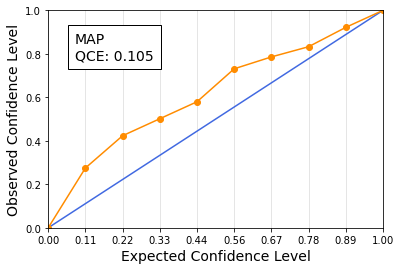

In [31]:
from training.sgld import SGLDModule, sgld

torch.manual_seed(0)

batch_size = 32
dataset = UCIDatasets("housing", "/mnt/c/Uni/Bachelor/Code/data/", test_percentage=0.2, subsample=1)
trainloader = torch.utils.data.DataLoader(dataset.train_set, batch_size, shuffle=False)
testloader = torch.utils.data.DataLoader(dataset.test_set, batch_size, shuffle=False)
init_var = torch.tensor(0.25).to(device).repeat(dataset.out_dim)
def make_res(name, eval_fn, samples):
    return RegressionResults(testloader, name, eval_fn, samples, device, target_mean=dataset.target_mean, target_std=dataset.target_std)

layers = [
    ("fc", (dataset.in_dim, 50)),
    ("relu", ()),
    ("fc", (50, 1)),
    ("gauss", (init_var, False))
]
model = SGLDModule(layers, 1000, 5)
model.train_model(6000, nll_loss, sgld(1e-5, 0.5), trainloader, batch_size, device, report_every_epochs=100)
#model.train_model(50, nll_loss, adam(1e-2), trainloader, batch_size, device, mc_samples=10, report_every_epochs=100)
res = make_res("MAP", model.infer, 1000)

plot_table("Power", [[res]])
plot_calibration("MAP", res, plt.subplot())

In [9]:
def eval_on_uci(name, dataset_name, config):
    results = [[] for _ in range(6)]
    for seed in range(5):
        print(f"\n\n================== Seed {seed} ==================")
        torch.manual_seed(seed)
        batch_size = 32
        dataset = UCIDatasets(dataset_name, "./data/", test_percentage=0.2)
        trainloader = torch.utils.data.DataLoader(dataset.train_set, batch_size, shuffle=False)
        testloader = torch.utils.data.DataLoader(dataset.test_set, batch_size, shuffle=False)

        init_var = torch.tensor(0.1).to(device)
        learn_var = True
        layers = [
            ("fc", (dataset.in_dim, 50)),
            ("relu", ()),
            ("fc", (50, 1))
        ]
        def make_res(name, eval_fn, samples):
            return RegressionResults(testloader, name, eval_fn, samples, device, fit_gaussian=False, target_mean=dataset.target_mean, target_std=dataset.target_std)


        print("\n=========== PP training ===========")
        pp = GaussWrapper(PointPredictor(layers), init_var, learn_var)
        pp.train_model(config[0], sgd(0.01), "mean", trainloader, batch_size, device, report_every_epochs=0)
        pp_res = make_res("Point Predictor", pp.infer, 1000)
        results[0].append(pp_res)


        print("\n========== SWAG training ==========")
        torch.manual_seed(seed)
        swag_config = {
            "start_epoch": config[1][0],
            "update_every_batches": len(trainloader),
            "deviation_samples": config[1][2]
        }
        swag = GaussWrapper(SwagModel(layers, swag_config), init_var, learn_var)
        swag.train_model(config[1][1], sgd(0.01), "mean", trainloader, batch_size, device, report_every_epochs=0)
        swag_res = make_res("SWAG", swag.infer, 1000)
        results[1].append(swag_res)

        print("\n========== SWAG-Diag training ==========")
        torch.manual_seed(seed)
        diag_swag_config = {
            "start_epoch": config[1][0],
            "update_every_batches": len(trainloader),
            "deviation_samples": config[1][2],
            "use_low_rank_cov": False
        }
        diag_swag = GaussWrapper(SwagModel(layers, diag_swag_config), init_var, learn_var)
        diag_swag.train_model(config[1][1], sgd(0.01), "mean", trainloader, batch_size, device, report_every_epochs=0)
        diag_swag_res = make_res("SWAG-Diagonal", diag_swag.infer, 1000)
        results[2].append(diag_swag_res)


        print("\n======== Ensemble training ========")
        torch.manual_seed(seed)
        ensemble = Ensemble([GaussWrapper(PointPredictor(layers), init_var, learn_var) for _ in range(5)])
        ensemble.train_model(config[2], sgd(0.01), "mean", trainloader, batch_size, device, report_every_epochs=0)
        ensemble_res = make_res("Ensemble-5", ensemble.infer, 1000)
        results[3].append(ensemble_res)


        print("\n======= MC Dropout training =======")
        torch.manual_seed(seed)
        mc_dropout = GaussWrapper(MonteCarloDropoutModule(layers, 0.1), init_var, learn_var)
        mc_dropout.train_model(config[3], sgd(0.01), "mean", trainloader, batch_size, device, report_every_epochs=0)
        mc_res = make_res("Monte Carlo Dropout", mc_dropout.infer, 1000)
        results[4].append(mc_res)


        print("\n=========== BBB training ==========")
        torch.manual_seed(seed)
        bbb_prior = GaussianPrior(0, 1)
        bbb = GaussWrapper(BBBModel(bbb_prior, "activations", layers), init_var, learn_var)
        bbb.train_model(config[4], sgd(lr=0.005), "mean", trainloader, batch_size, device, report_every_epochs=0)
        bbb_res = make_res("Bayes By Backprop", bbb.infer, 1000)
        results[5].append(bbb_res)


    print("\n\n============ Results ============")
    plot_table(name, results, f"results/UCI/{dataset_name}.txt")

    return results

In [10]:
boston_results = eval_on_uci("Boston Housing", "housing", [50, (50, 75, 25), 50, 250, 1000])



================== Seed 0 ==================

=========== PP training ===========
Final loss -0.01912114769220352

========== SWAG training ==========
Final loss -0.021451415494084358
SWAG: Collected 25 out of 25 deviation samples and 25 parameter samples

========== SWAG-Diag training ==========
Final loss -0.021451415494084358
SWAG: Collected 25 out of 25 deviation samples and 25 parameter samples

======== Ensemble training ========
Training ensemble member 0
Final loss -0.018130911514163017
Training ensemble member 1
Final loss -0.01754862442612648
Training ensemble member 2
Final loss -0.018425310030579567
Training ensemble member 3
Final loss -0.019200574606657028
Training ensemble member 4
Final loss -0.01858748495578766

======= MC Dropout training =======
Final loss -0.022725045680999756

=========== BBB training ==========
Final loss 0.5981854200363159


================== Seed 1 ==================

=========== PP training ===========
Final loss -0.021689068526029587

=====

In [19]:
concrete_results = eval_on_uci("Concrete", "concrete", [50, (50, 75, 25), 50, 250, 1000])


=========== PP training ===========
Epoch 0: loss 0.02510601095855236
Epoch 100: loss -0.004837113432586193
Final loss -0.00677541783079505

========== SWAG training ==========
Epoch 0: loss 0.023640066385269165
SWAG: Collected 0 out of 50 deviation samples and 0 parameter samples
Epoch 100: loss -0.004983428865671158
SWAG: Collected 0 out of 50 deviation samples and 0 parameter samples
Final loss -0.0066817160695791245

======== Ensemble training ========
Training ensemble member 0
Epoch 0: loss 0.023640066385269165
Epoch 100: loss -0.004983428865671158
Final loss -0.0066817160695791245
Training ensemble member 1
Epoch 0: loss 0.029204111546278
Epoch 100: loss -0.0049481517635285854
Final loss -0.006831923499703407
Training ensemble member 2
Epoch 0: loss 0.02609897591173649
Epoch 100: loss -0.00476755341514945
Final loss -0.00648775277659297
Training ensemble member 3
Epoch 0: loss 0.022709796205163002
Epoch 100: loss -0.005134688690304756
Final loss -0.0066888174042105675
Training 

In [21]:
energy_results = eval_on_uci("Energy", "energy", [50, (50, 75, 25), 50, 250, 1000])


=========== PP training ===========
Epoch 0: loss 0.008868275210261345
Epoch 100: loss -0.012672074139118195
Final loss -0.014255918562412262

========== SWAG training ==========
Epoch 0: loss 0.006837711203843355
SWAG: Collected 0 out of 50 deviation samples and 0 parameter samples
Epoch 100: loss -0.012453894130885601
SWAG: Collected 0 out of 50 deviation samples and 0 parameter samples
Final loss -0.014394803903996944
SWAG: Collected 50 out of 50 deviation samples and 50 parameter samples

======== Ensemble training ========
Training ensemble member 0
Epoch 0: loss 0.006837711203843355
Epoch 100: loss -0.012453894130885601
Final loss -0.014394803903996944
Training ensemble member 1
Epoch 0: loss 0.011188078671693802
Epoch 100: loss -0.012472706846892834
Final loss -0.01427349541336298
Training ensemble member 2
Epoch 0: loss 0.01010822132229805
Epoch 100: loss -0.012264619581401348
Final loss -0.014361950568854809
Training ensemble member 3
Epoch 0: loss 0.008416597731411457
Epoch 

In [52]:
power_results = eval_on_uci("Power", "power", [20, (10, 30, 30), 20, 100, 200])



================== Seed 0 ==================

=========== PP training ===========
Final loss -0.0281926691532135

========== SWAG training ==========
Final loss -0.028454666957259178
SWAG: Collected 20 out of 30 deviation samples and 20 parameter samples

======== Ensemble training ========
Training ensemble member 0
Final loss -0.028201373293995857
Training ensemble member 1
Final loss -0.02795032411813736
Training ensemble member 2
Final loss -0.028290176764130592
Training ensemble member 3
Final loss -0.028275756165385246
Training ensemble member 4
Final loss -0.028149623423814774

======= MC Dropout training =======
Final loss -0.026856543496251106

=========== BBB training ==========
Final loss -0.015991250053048134


================== Seed 1 ==================

=========== PP training ===========
Final loss -0.02813655324280262

========== SWAG training ==========
Final loss -0.02831965498626232
SWAG: Collected 20 out of 30 deviation samples and 20 parameter samples

======== 

OSError: [Errno 22] Invalid argument: 'results/UCI/<experiments.uci.UCIDatasets object at 0x0000014C21B03D60>.txt'

In [25]:
wine_results = eval_on_uci("Wine", "wine", [50, (50, 75, 25), 50, 250, 1000])


=========== PP training ===========
Epoch 0: loss 0.025987522676587105
Epoch 100: loss 0.002189759397879243
Final loss 0.001964748138561845

========== SWAG training ==========
Epoch 0: loss 0.02562892623245716
SWAG: Collected 0 out of 50 deviation samples and 0 parameter samples
Epoch 100: loss 0.0021789725869894028
SWAG: Collected 0 out of 50 deviation samples and 0 parameter samples
Final loss 0.001969756791368127
SWAG: Collected 50 out of 50 deviation samples and 50 parameter samples

======== Ensemble training ========
Training ensemble member 0
Epoch 0: loss 0.02562892623245716
Epoch 100: loss 0.0021789725869894028
Final loss 0.001969756791368127
Training ensemble member 1
Epoch 0: loss 0.026135500520467758
Epoch 100: loss 0.0020876238122582436
Final loss 0.0018444418674334884
Training ensemble member 2
Epoch 0: loss 0.02367119863629341
Epoch 100: loss 0.002141875447705388
Final loss 0.0019124465761706233
Training ensemble member 3
Epoch 0: loss 0.02484646998345852
Epoch 100: lo

In [27]:
yacht_results = eval_on_uci("Yacht", "yacht", [50, (50, 75, 25), 50, 250, 1000])


=========== PP training ===========
Epoch 0: loss 0.033470556139945984
Epoch 100: loss -0.008822107687592506
Final loss -0.014454040676355362

========== SWAG training ==========
Epoch 0: loss 0.029626406729221344
SWAG: Collected 0 out of 50 deviation samples and 0 parameter samples
Epoch 100: loss -0.008579614572227001
SWAG: Collected 0 out of 50 deviation samples and 0 parameter samples
Final loss -0.013914953917264938
SWAG: Collected 50 out of 50 deviation samples and 50 parameter samples

======== Ensemble training ========
Training ensemble member 0
Epoch 0: loss 0.029626406729221344
Epoch 100: loss -0.008579614572227001
Final loss -0.013914953917264938
Training ensemble member 1
Epoch 0: loss 0.030688820406794548
Epoch 100: loss -0.007360842078924179
Final loss -0.012482451274991035
Training ensemble member 2
Epoch 0: loss 0.030731407925486565
Epoch 100: loss -0.00816725566983223
Final loss -0.013729331083595753
Training ensemble member 3
Epoch 0: loss 0.035993993282318115
Epoch

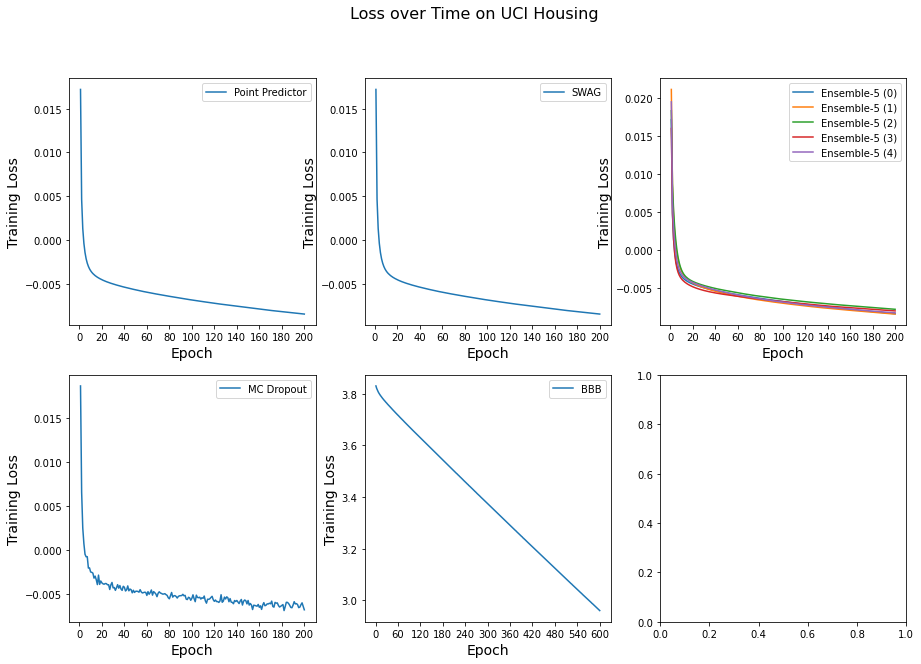

In [232]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
fig.suptitle("Loss over Time on UCI Housing", fontsize=16)
plot_losses("Point Predictor", pp.all_losses(), axes[0,0])
plot_losses("SWAG", swag.all_losses(), axes[0,1])
plot_losses("Ensemble-5", ensemble.all_losses(), axes[0,2])
plot_losses("MC Dropout", mc_dropout.all_losses(), axes[1,0])
plot_losses("BBB", bbb.all_losses(), axes[1,1])

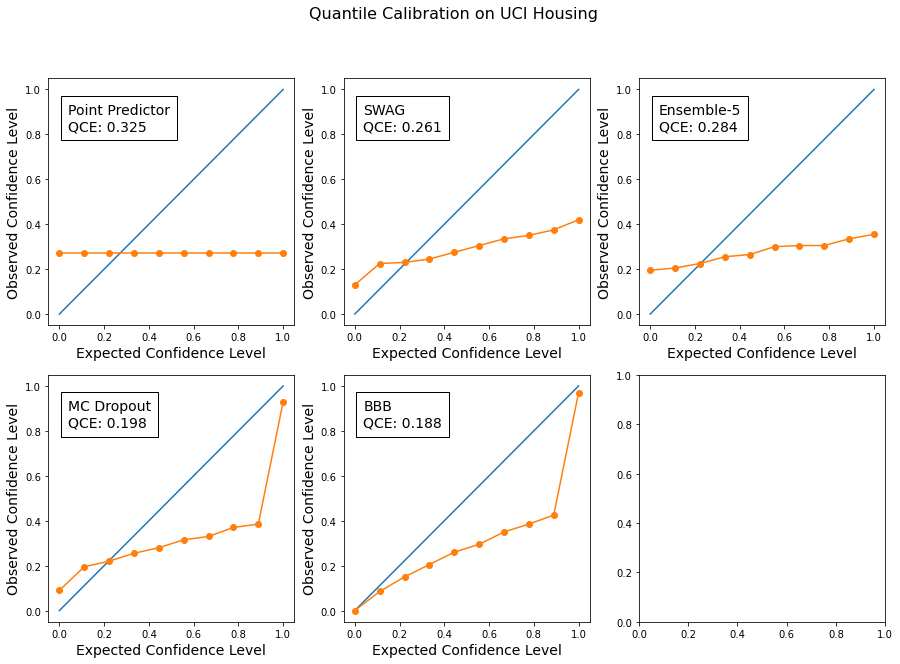

In [233]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
fig.suptitle("Quantile Calibration on UCI Housing", fontsize=16)
plot_calibration("Point Predictor", pp_res, axes[0,0])
plot_calibration("SWAG", swag_res, axes[0,1])
plot_calibration("Ensemble-5", ensemble_res, axes[0,2])
plot_calibration("MC Dropout", mc_res, axes[1,0])
plot_calibration("BBB", bbb_res, axes[1,1])

In [235]:
plot_table("Boston Housing", [pp_res, swag_res, ensemble_res, mc_res, bbb_res])

| Boston Housing      |   Avg LML |   Mean MSE |   MSE of Means |   QCE |
|---------------------+-----------+------------+----------------+-------|
| Point Predictor     |    -2.554 |      9.147 |          9.147 | 0.325 |
| SWAG                |    -2.535 |     10.815 |          9.95  | 0.261 |
| Ensemble-5          |    -2.465 |      8.916 |          8.462 | 0.284 |
| Monte Carlo Dropout |    -2.572 |     12.07  |         10.494 | 0.198 |
| Bayes By Backprop   |    -2.904 |     26.164 |         19.179 | 0.188 |
